In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import random
import time
import os
import copy
import cv2
from PIL import Image
from IPython.display import display
from time import time

cudnn.benchmark = True
plt.ion()   # interactive mode

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


last time i had change 64 crop to 224

In [2]:
class SingleImageDataset(Dataset):
    def __init__(self, path_to_file, crop_size = 256, segment_number = 25, transform = None):
        self.crop_size = crop_size
        self.segment_number = segment_number
        img = cv2.imread(path_to_file)
        img_size = img.shape[0]
        new_size = crop_size * segment_number
        self.im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img_size < new_size:
            self.im = cv2.resize(self.im, (new_size,new_size), interpolation = cv2.INTER_CUBIC)
        else:
            self.im = cv2.resize(self.im, (new_size,new_size), interpolation = cv2.INTER_AREA)
        self.crop_number = segment_number * segment_number
        self.transform = transform
        self.cls_crops = []
        self.__init_classes()

        
    def cls2ltrb(self, cls_id):
        assert cls_id < self.crop_number, f'class id must be less than num of bids {self.crop_number}'
        row = cls_id//self.segment_number
        col = cls_id%self.segment_number
        left = col * self.crop_size
        top = row * self.crop_size
        right, bottom = left + self.crop_size, top + self.crop_size
        return left, top, right, bottom

    def get_crop_by_id(self, cls_id):
        ltrb = self.cls2ltrb(cls_id)
        crop = self.im[ltrb[0]:ltrb[2], ltrb[1]:ltrb[3]]
        return crop
    
    def __init_classes(self):
        for cls_id in range(self.crop_number):
            row = cls_id//self.segment_number
            col = cls_id%self.segment_number
            if row == 0 or col == 0:
                continue
            if row == (self.segment_number-1) or col == (self.segment_number-1):
                continue
            self.source_crop(cls_id)
            for i in range(12):
                self.shift_crop(cls_id)
                self.scale_and_rotate(cls_id)
                if i > 2:
                    continue
                self.blur_crop(cls_id)
                self.clahe_crop(cls_id)
                
    def source_crop(self, cls_id):
        ltrb = self.cls2ltrb(cls_id)
        crop = self.im[ltrb[0]:ltrb[2], ltrb[1]:ltrb[3]]
        self.cls_crops.append([crop, cls_id])
    
    def __len__(self):
        return len(self.cls_crops)
    
    def get_ovect(self, cls_id):
        self.ovect = torch.zeros(self.crop_number)
        self.ovect[cls_id] = 1.0
        return self.ovect
    
    def __getitem__(self, idx):
        # get randomly positioned crop
        crop, cls_id = self.cls_crops[idx]
        #ovect = self.get_ovect(cls_id)
        target = [cls_id]
        target = torch.Tensor(target).type(torch.LongTensor)
        if self.transform:
            crop = self.transform(crop)
        return crop, target
        
    def shift_crop(self, cls_id):
        quarter = int(self.crop_size/4)
        ltrb = self.cls2ltrb(cls_id)
        shift_x = np.random.randint(0, quarter)
        shift_y = np.random.randint(0, quarter)
        sign_x = np.random.choice([1, -1])
        sign_y = np.random.choice([1, -1])
        shift_ltrb = (ltrb[0] + sign_x * shift_x,
                      ltrb[1] + sign_y * shift_y,
                      ltrb[2] + sign_x * shift_x,
                      ltrb[3] + sign_y * shift_y)
        shift_ltrb = [max(0,i) for i in shift_ltrb]
        crop = self.im[shift_ltrb[0]:shift_ltrb[2], shift_ltrb[1]:shift_ltrb[3]]
        crop = self.change_brightness(crop)
        self.cls_crops.append([crop, cls_id])
            
    def scale_and_rotate(self, cls_id):
        # Rotate
        half_size = self.crop_size/2
        ltrb = (self.cls2ltrb(cls_id))
        cx, cy = int(ltrb[0]+(ltrb[2]-ltrb[0])/2), int(ltrb[1]+(ltrb[3]-ltrb[1])/2)
        scale = 2
        cr_w = int(half_size*scale)
        cr_h = int(half_size*scale)
        ltrb = cx - cr_h, cy - cr_w, cx + cr_h, cy + cr_w
        ltrb = [max(0,i) for i in ltrb]
        ltrb = tuple(ltrb)
        image = self.im[ltrb[0]:ltrb[2], ltrb[1]:ltrb[3]]
        angle = np.random.randint(5, 350)
        rot_mat = cv2.getRotationMatrix2D((self.crop_size, self.crop_size), angle, 1)
        result = cv2.warpAffine(image, rot_mat, image.shape[:2], flags=cv2.INTER_LINEAR)
        cx, cy = int(result.shape[0]/2), int(result.shape[1]/2)
        
        ltrb = cx - half_size, cy - half_size, cx + half_size, cy + half_size
        ltrb = [max(0,i) for i in ltrb]
        ltrb = [int(i) for i in ltrb]
        r_img = result[ltrb[0]:ltrb[2], ltrb[1]:ltrb[3]]
        # Scale
        scale = np.random.uniform(0.5, 1.5)
        scale = np.round(scale, 4)
        if scale < 1:
            crop = cv2.resize(r_img, (0,0), fx=scale, fy=scale, interpolation = cv2.INTER_AREA)
            crop = cv2.resize(crop, (self.crop_size,self.crop_size))
        else:
            crop = cv2.resize(r_img, (0,0), fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)
            crop = cv2.resize(crop, (self.crop_size,self.crop_size))
            
        self.cls_crops.append([crop, cls_id])
    
    def blur_crop(self, cls_id):
        kernel_size = np.random.randint(3, 11)
        if kernel_size%2 == 0:
            kernel_size +=1
        kernel_size = (kernel_size, kernel_size)
        sigma = np.random.randint(1, 4)
        ltrb = self.cls2ltrb(cls_id)
        image = self.im[ltrb[0]:ltrb[2], ltrb[1]:ltrb[3]]
        img_blur = cv2.GaussianBlur(image, kernel_size, sigma)
        self.cls_crops.append([img_blur, cls_id])
        
    def clahe_crop(self, cls_id):
        ltrb = self.cls2ltrb(cls_id)
        image = self.im[ltrb[0]:ltrb[2], ltrb[1]:ltrb[3]]
        limit = np.random.randint(1, 6)
        clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=(8,8))
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l_new = clahe.apply(l)  # apply CLAHE to the L-channel
        lab = cv2.merge((l_new,a,b))  # merge channels
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        self.cls_crops.append([img, cls_id])
    
    def change_brightness(self, img):
        if np.random.random() > 0.5:
            return self.increase_brightness(img)
        else:
            return self.decrease_brightness(img)
    
    def increase_brightness(self, img):
        value = np.random.randint(0, 21)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    def decrease_brightness(self, img):
        value = np.random.randint(0, 21)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        lim = value
        v[v < lim] = 0
        v[v >= lim] -= value
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    
    
transform_pipe = transforms.Compose([
    # Convert image to tensor with image values in [0, 1]
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])


path_to_img = 'iamge.jpg'
# 64x25 112×15 224x7
crop_size = 224
segment_number = 7

tic = time()
train_dataset = SingleImageDataset(path_to_img, 
                         crop_size = crop_size,
                         segment_number=segment_number, 
                         transform=transform_pipe)
print(f'time elapsed for dataset initialization {time()-tic:.4f}')

time elapsed for dataset initialization 2.7463


In [3]:
train_dataset.crop_number

49

In [4]:
len_dataset = len(train_dataset)
len_dataset

775

In [5]:
train_dataset[0][0].size()

torch.Size([3, 224, 224])

## Dataset check in

n = 0, cls_id - 8
got crop with id (tensor([8]),)


/tmp/ipykernel_10070/3197083619.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  canvas = canvas.resize((2*cnvs_w, 2*cnvs_h), Image.ANTIALIAS)


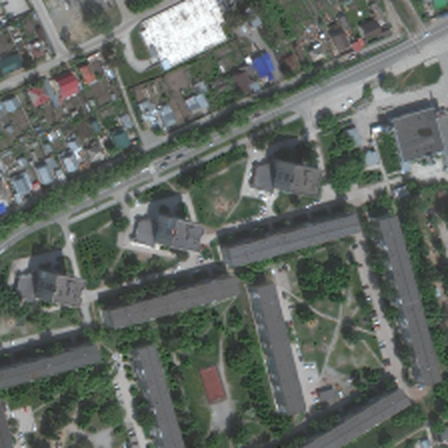

/tmp/ipykernel_10070/3197083619.py:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  canvas = canvas.resize((cnvs_w, cnvs_h), Image.ANTIALIAS)


In [6]:
t2pil = transforms.ToPILImage()
canvas = Image.new(mode="RGB", 
                       size=(crop_size, crop_size))
for n in range(1):
    crop, cls_id = train_dataset.cls_crops[n]
    print(f'n = {n}, cls_id - {cls_id}')
    ovect = train_dataset.get_ovect(cls_id)
    cr_id = torch.where(ovect==1)#[0]
    print(f'got crop with id {cr_id}')
    if n >= 0:
        canvas.paste(t2pil(crop), (0, 0))
        if n < 1:
            cnvs_w, cnvs_h = canvas.size
            #cnvs_w, cnvs_h = cnvs_w, cnvs_h
        canvas = canvas.resize((2*cnvs_w, 2*cnvs_h), Image.ANTIALIAS)
        display(canvas)
        canvas = canvas.resize((cnvs_w, cnvs_h), Image.ANTIALIAS)
    if n == 124:
        break

In [76]:
train_indices = int(len_dataset*0.90)
test_indices = int(len_dataset*0.1)
train_indices

697

In [77]:
test_dataset = SingleImageDataset(path_to_img,
                                 crop_size = crop_size,
                                 segment_number=segment_number, 
                                 transform=transform_pipe
                                 )

test_dataset.cls_crops = test_dataset.cls_crops[train_indices:]

In [78]:
print(len(test_dataset))

78


In [79]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True, num_workers=1
)

In [80]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True, num_workers=1
)

In [81]:
dataloaders = {"train": train_loader,
               "test": test_loader
              }

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc =torch.nn.Linear(
         in_features=num_ftrs,
         out_features=train_dataset.crop_number
         )
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [82]:
crop, _ = train_dataset.cls_crops[16]
crop.shape

(224, 224, 3)

In [83]:
img, lbl = next(iter(train_loader))
lbl.shape

torch.Size([16, 1])

__TRAIN__

In [86]:
TRAIN = True
EPOCHS = 250

optimizer = optim.Adam(model.parameters(), lr= 0.0001) 
# loss function
criterion = nn.CrossEntropyLoss() 

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1.0

if TRAIN:
    for i in range(EPOCHS):
        print(f"epoch: {i + 1}")
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            samples = 0
            loss_sum = 0
            correct_sum = 0
            for j, batch in enumerate(dataloaders[phase]):
                X, labels = batch
                labels = torch.flatten(labels)
                X = X.cuda()
                labels = labels.cuda()
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    y = model(X)

                    loss = criterion(y, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    loss_sum += loss.item() * X.shape[0]
                    samples += X.shape[0]

            # Print epoch statistics
            epoch_loss = float(loss_sum) / float(samples)
            print("{} loss: {}".format(phase, epoch_loss))

            # Deep copy the model
            if phase == "test" and best_loss > epoch_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f"res50_{crop_size}.pth")
            
            # Early stopping
            if phase == "test":
                pass

    last_model_wts = copy.deepcopy(model.state_dict())
    torch.save(last_model_wts, f"res50_last_{crop_size}.pth")


epoch: 1
train loss: 1.6321886540997412
test loss: 0.07652978522655292
epoch: 2
train loss: 0.14648634529882862
test loss: 0.011021892229715982
epoch: 3
train loss: 0.044161137707771796
test loss: 0.008602657809089392
epoch: 4
train loss: 0.029679713794781317
test loss: 0.006325951944559048
epoch: 5
train loss: 0.017164542396222393
test loss: 0.002540486542364726
epoch: 6
train loss: 0.011493316811899985
test loss: 0.0029030466386570763
epoch: 7
train loss: 0.010447741173688442
test loss: 0.0012418730632187082
epoch: 8
train loss: 0.007186667947999893
test loss: 0.00204082122609879
epoch: 9
train loss: 0.006419356631175164
test loss: 0.0011712126045798261
epoch: 10
train loss: 0.005822465667320836
test loss: 0.0010937204769549843
epoch: 11
train loss: 0.00713122539702923
test loss: 0.0012764250949168434
epoch: 12
train loss: 0.011674508651898754
test loss: 0.0019958147671646797
epoch: 13
train loss: 0.0072581475979137805
test loss: 0.001738537016372459
epoch: 14
train loss: 0.004062891

## Model prediction check in

In [88]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    #e_x = torch.exp(x - torch.max(x))
    #return e_x / e_x.sum()
    return torch.softmax(x,dim=0)

In [89]:
if not TRAIN:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    PATH = './res50_last.pth'
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(
                 in_features=num_ftrs,
                 out_features=train_dataset.crop_number
                 )
    model.load_state_dict(torch.load(PATH))
    model.to(device)


In [95]:
t2pil = transforms.ToPILImage()
n = 0 # all
r = 0 # right
verified = []
i = 0 
while i < 50:
    
    for crop, cls_id in train_loader:
        
        crop = crop.cuda()
        prediction = model(crop)
        for j in range(len(prediction)):
            canvas = Image.new(mode="RGB", 
                       size=(crop_size*2, crop_size))
            canvas.paste(t2pil(crop[j]), (0, 0))
            predict_id = torch.where(prediction[j] == torch.max(prediction[j]))
            try:
                c0 = train_dataset.get_crop_by_id(int(predict_id[0]))
            except:
                c0 = train_dataset.get_crop_by_id(int(predict_id[0][-1]))
                if len(predict_id[0]) > 6:
                    verified.append(cls_id[0][0])
                    n += 1
                    r += 1
                    continue
            n += 1
            canvas.paste(t2pil(c0), (crop_size, 0))
            print(f'cls_id {int(cls_id[j])}') #' predict {predict_id[0].to("cpu").flip(0)}')
            top_five = torch.sort(prediction[j])[1][-3:]
            top_five = top_five.to('cpu').flip(0)
            scores = softmax(prediction[j])
            scores = scores[top_five].cpu().detach().numpy()
            print('top_3', top_five.detach().numpy())
            print('scores', np.round(scores, 5))
            cnvs_w, cnvs_h = canvas.size
            canvas = canvas.resize((cnvs_w*2, cnvs_h*2), Image.ANTIALIAS)
            if cls_id[0][0] in verified:
                print('verified')
                n -= 1
                continue
            verified.append(cls_id[0][0])
            if cls_id[0][0] in list(top_five):
                r += 1
        break
    i += 1

print(f'accuracy top_3 = {r/n}')

cls_id 19
top_3 [19 12 26]
scores [1. 0. 0.]
cls_id 16
top_3 [16  9 17]
scores [1. 0. 0.]
verified
cls_id 10
top_3 [10 22  9]
scores [1. 0. 0.]
verified
cls_id 15
top_3 [15 22  8]
scores [1. 0. 0.]
verified
cls_id 36
top_3 [36 37 38]
scores [1. 0. 0.]
verified
cls_id 18
top_3 [18 11  9]
scores [1. 0. 0.]
verified
cls_id 32
top_3 [32 33 36]
scores [1. 0. 0.]
verified
cls_id 10
top_3 [10 11 18]
scores [1. 0. 0.]
verified
cls_id 31
top_3 [31 38 24]
scores [1. 0. 0.]
verified
cls_id 16
top_3 [16 30 17]
scores [1. 0. 0.]
verified
cls_id 37
top_3 [37 38 36]
scores [1. 0. 0.]
verified
cls_id 32
top_3 [32 36 30]
scores [1. 0. 0.]
verified
cls_id 9
top_3 [ 9 31 17]
scores [1. 0. 0.]
verified
cls_id 25
top_3 [25 32 38]
scores [1. 0. 0.]
verified
cls_id 24
top_3 [24 31 32]
scores [1. 0. 0.]
verified
cls_id 24
top_3 [24 31 32]
scores [1. 0. 0.]
verified


/tmp/ipykernel_18707/2645976627.py:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  canvas = canvas.resize((cnvs_w*2, cnvs_h*2), Image.ANTIALIAS)


cls_id 9
top_3 [ 9 31  8]
scores [1. 0. 0.]
cls_id 10
top_3 [10  9 24]
scores [1. 0. 0.]
verified
cls_id 29
top_3 [29 24 17]
scores [1. 0. 0.]
verified
cls_id 29
top_3 [29 22 24]
scores [1. 0. 0.]
verified
cls_id 37
top_3 [37 30 38]
scores [1. 0. 0.]
verified
cls_id 30
top_3 [30 32 22]
scores [1. 0. 0.]
verified
cls_id 10
top_3 [10 11 18]
scores [1. 0. 0.]
verified
cls_id 38
top_3 [38 39 33]
scores [1. 0. 0.]
verified
cls_id 26
top_3 [26 29 33]
scores [1. 0. 0.]
verified
cls_id 18
top_3 [18  9 11]
scores [1. 0. 0.]
verified
cls_id 18
top_3 [18 11  9]
scores [1. 0. 0.]
verified
cls_id 40
top_3 [40 39 36]
scores [1. 0. 0.]
verified
cls_id 18
top_3 [18 11  9]
scores [1. 0. 0.]
verified
cls_id 16
top_3 [16 30  9]
scores [1. 0. 0.]
verified
cls_id 15
top_3 [15 22  8]
scores [1. 0. 0.]
verified
cls_id 30
top_3 [30 29 32]
scores [1. 0. 0.]
verified
cls_id 40
top_3 [40 39 36]
scores [1. 0. 0.]
cls_id 36
top_3 [36 33 32]
scores [1. 0. 0.]
verified
cls_id 40
top_3 [40 39 36]
scores [1. 0. 0.]
ve

__export .onnx__

In [98]:
model.to("cpu")
#x = torch.randn((1, 3, 224, 224))
x = torch.randn((1, 3, crop_size, crop_size))
model.eval()
torch.onnx.export(model, x, f'./resnet50_{crop_size}.onnx', opset_version=12, input_names=['input'], output_names=['output'])

__model.pt SAVE__

In [99]:
input_tensor = torch.randn((1, 3, crop_size, crop_size))
model.to("cpu")
model.eval()
traced_script_module = torch.jit.trace(model, input_tensor)
traced_script_module.save(f"resnet50_{crop_size}.pt")